# Project: Eligibility Screening of Gun Buyers in the U.S
## Analysis of the NICS and U.S. Census data

> Gun laws in the U.S. are a delicate political topic and make America stand out in the Western hemisphere in a certain way. There are social phenoma and violent incidents that are suggested to be loosly connected to the prevelance and relative easiness with that many people can buy firearms. Research is hard to come by, which it is fair to say is not by accident. But answers more fundamental which start an earlier stage are suprisingly difficult to come by: E.g. How many guns are their actually in circulation? How many guns does a person have and where in the country are pockets of unusually high concentration of firearms? What are the "demographics" of guns?

### Table of Contents
<ol type="I">
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data</a></li>
<li><a href="#eda">Exploratory Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ol>

<a id='intro'></a>
## I. Introduction

NCIS, the FBI's National Instant Criminal Background Check System is used to determine whether a prospective buyer is eligible to buy firearms in the United States. The data used in this analysis forward is a monthly summary of gun sales at state level and provides detailed insights into the dynamics of state firearms markets dating from November 1998 to September 2017, thus spanning an entirety of 18 years and 10 months. It is complemented by data from the U.S. Census in 2016 providing on 65 non-null variables with information about demographics and population dynamics. The significance in terms of dynamics is limited though, as only a fraction of the variables contains data on at least two points in time. Nonetheless, we hope to be able to gain valuable intuition into the demand side of private gun ownership irrespective of how these firearms are put to use.

To infer any numbers of firearms in public circulation is very difficult from the NCIS data, as multiple gun sales can be grouped together as one instance of a background check. The NYT has come across this problem before and provided some <a href="https://github.com/NYTimes/gunsales#getting-gun-sales-estimates-from-background-checks">suggestions</a> for potential ways to address this. It still remains a good proxy for market dynamics, thus we take the numbers as a given and investigate the following 3 questions: <a href='#quest1'>i)</a> How do demographic variations across states affect demand and total number of background checks, <a href='#quest2'>ii)</a> can we proxy a possible correlation between the social and economic composition of a state to its tendency of being more or less embracing towards private gun ownership and <a href='#quest3'>iii)</a> can we comprehensively visualise national dynamics for the time period between 2010 and 2016.

In [1]:
# Load all dependencies for the forthcoming analysis

import sys

###

# Honestly- and please don't be mad - but it's just so
# incredibly tedious to work with outdated dependencies

!{sys.executable} -m pip install seaborn==0.9.0

###

import math
import warnings

import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

# Render plots within the Notebook

%matplotlib inline
plt.style.use('bmh')

# Toggle user and deprecation warnings
# Critical warnings have been fixed

warnings.filterwarnings('ignore')

    100% |████████████████████████████████| 215kB 2.0MB/s eta 0:00:01
  Found existing installation: seaborn 0.8.1
    Uninstalling seaborn-0.8.1:
      Successfully uninstalled seaborn-0.8.1
You are using pip version 9.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


<a id='wrangling'></a>
## Data

The NCIS data has been parsed from a pdf file to an xlsx file. We have checked the data for visual consistency before uploading it to python and would like to use the time axis as index. Unfortunately, the parser did not seem to have detected the date data format.

In [2]:
# The NCIS data is provided in excel format, the
# census data as comma separated file

ncis = pd.read_excel('gun_data.xlsx', 
                     sheetname='Sheet1', 
                     index_col=0, 
                     header=0)
census = pd.read_csv('U.S. Census Data.csv')

# The date in the ncis data was provided in the 
# format %Y-%m and the parser did not detect it.
# We pass it another attempt, this time explicitly,
# and assert that it worked

ncis.index = pd.to_datetime(ncis.index)
assert ncis.index.is_all_dates

# Control structure of the ncis data set...

ncis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12485 entries, 2017-09-01 to 1998-11-01
Data columns (total 26 columns):
state                        12485 non-null object
permit                       12461 non-null float64
permit_recheck               1100 non-null float64
handgun                      12465 non-null float64
long_gun                     12466 non-null float64
other                        5500 non-null float64
multiple                     12485 non-null int64
admin                        12462 non-null float64
prepawn_handgun              10542 non-null float64
prepawn_long_gun             10540 non-null float64
prepawn_other                5115 non-null float64
redemption_handgun           10545 non-null float64
redemption_long_gun          10544 non-null float64
redemption_other             5115 non-null float64
returned_handgun             2200 non-null float64
returned_long_gun            2145 non-null float64
returned_other               1815 non-null float64


Without background knowledge it is not quite easy to make sense out of what this data is exactly meant to represent. Luckily, there are helpful other resources and notes from prior researchers who have already worked with the dataset:
- The <a href="https://www.fbi.gov/file-repository/nics_firearm_checks_-_month_year_by_state_type.pdf/view">original data set</a> was published by the FBI and is accessible as pdf sheet.
- <a href="https://github.com/BuzzFeedNews/nics-firearm-background-checks">BuzzFeedNews</a> has kindly parsed the data into a readable tabular format.
- The FBI's <a href="https://www.fbi.gov/file-repository/nics-firearms-licensee-manual-111811.pdf/view">Federal Firearms License Manual</a> provides (<a href="https://www.fbi.gov/file-repository/nics-participation-map.pdf/view">mostly legally binding</a>) guidance about when to perform a background check.
- <a href="https://www.thetrace.org/2015/11/black-friday-gun-sales-background-checks/">The Trace</a> and the <a href="https://github.com/NYTimes/gunsales#getting-gun-sales-estimates-from-background-checks">NYTimes</a> have already analysed the data set and published about key findings. Even more notably: They left invaluable remarks about the nature of the set and made proposals for how to handle it.

After consulting the above resources it becomes a bit more clear, what the key criteria for performing a background check are. Usually, a check form must be filled every time a business (i.e. vendor, pawner, etc.) and an individual trade firearms, unless a firearms permit is presented. That is also true, if the receipient is not the owner of the weapon. A repair job does not generally require a check, unless there is material reason to do so, or again, the receipient is not the owner.

Next, we glimpse at the census data.

In [3]:
# ... and the census data

census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 52 columns):
Fact              80 non-null object
Fact Note         28 non-null object
Alabama           65 non-null object
Alaska            65 non-null object
Arizona           65 non-null object
Arkansas          65 non-null object
California        65 non-null object
Colorado          65 non-null object
Connecticut       65 non-null object
Delaware          65 non-null object
Florida           65 non-null object
Georgia           65 non-null object
Hawaii            65 non-null object
Idaho             65 non-null object
Illinois          65 non-null object
Indiana           65 non-null object
Iowa              65 non-null object
Kansas            65 non-null object
Kentucky          65 non-null object
Louisiana         65 non-null object
Maine             65 non-null object
Maryland          65 non-null object
Massachusetts     65 non-null object
Michigan          65 non-null object
Minnesota

That does not look right. This way we do not know, what were the variables that were collected. We may want to look at it from a different angle: some of the data itself.

In [4]:
#  Let's have a glimpse at the date set itself.

census.head()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


The data provided by the U.S. census seems to have its variables provided as rows and its observations as columns with a range based index and variable names provided in the column 'Facts', which makes it difficult in this instance to provide a quick overview, over the informative value of the set, other than that it covers all 50 U.S. states. In the two usual formats of data analysis of 'wide' vs. 'long', it is in both cases good practice to establish rows as observations and columns as variables to analyse.
We could technically gather and spread the data again using the Facts column as keys. Or simply define the 'Facts' column as index and then transpose the entire Data Frame as below.

In [5]:
# Transpose data frame and establish the 'Facts' column as
# index, dropping all null or uninformative variables

census = census.set_index('Fact').T[1:]
census = census.iloc[:,:-20]

The census variable names are informative but verbose and cluttered. We curtail and convert them to snake case for easier referencing

In [6]:
# Manually assign new shortened variable names to Data Frame
# column with uniform styling format.

census.columns = ['pop_est_16',                 'pop_est_10',   
                  'pop_change',                 'pop_census', 
                  'under5_16',                  'under5_10', 
                  'under18_16',                 'under18_10',   
                  'over65_16',                  'over65_10',  
                  'female_16',                  'female_10', 
                  'white_alone',                'afr_american_alone',
                  'nat_american_alone',         'asian_alone',
                  'pacific_alone',              'multiple',
                  'lat_american',               'white_notlat_american_alone',
                  'veterans',                   'foreign_born', 
                  'housing_units_16',           'housing_units_10',   
                  'owner_occupied',             'owner_occupied_value_median', 
                  'mortgage_owner_cost_median', 'nomortgage_owner_cost_median',
                  'gross_rent_median',          'build_permits',
                  'households',                 'pers_per_hh',  
                  'more_than_1year_occupied',   'foreign_language_at_home',   
                  'high_school_and_better',     'bachelor_and_better',        
                  'disabled_under65',           'no_health_insur_under65',    
                  'civil_labor_force',          'civil_labor_force_female',   
                  'acc_food_sales',             'health_rev', 
                  'manufact_shipments',         'merchant_ws_sales',  
                  'retail_sales',               'retail_sales_per_cap',       
                  'mean_commute',               'hh_income_median',   
                  '1year_income_per_cap',       'poors',      
                  'empl_estab',                 'tot_employment', 
                  'ann_payroll',                'tot_employment_change',
                  'nonempl_estab',              'all_firms', 
                  'men_owned_firms',            'women_owned_firms', 
                  'minority_owned_firms',       'nonminority_owned_firms', 
                  'veteran_owned_firms',        'nonveteran_owned_firms', 
                  'pop_per_sqm',                'land_area_sqm', 
                  'fips_code']

Trying to reduce the floats to integer values throws a warning about NaNs and inf values. Even if at a later stage, when we are working with means and fractions, let us assume for now that we are working with counts, thus integers. It makes sense to fill all fields that contain no proper number as a zero-count. It may not accurately represent the real number of checks that have occurred in the given month, but it is likely the method that introduces the least artificial bias and may not be relevant after all, as the period of interest is the time after 2010.

In [7]:
# Fill all missing values and simplify data. As the values represent 
# individual counts, they all should be elements of the natural 
# numbers set.

ncis = ncis[(ncis.index >= '2010-01-01') & ('2016-12-01' >= ncis.index)]
ncis.iloc[:,1:] = ncis.iloc[:,1:].fillna(0).astype(int)
ncis.head(15)

,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
month,,,,,,,,,,,,,,,,,,,,,
2016-12-01,Alabama,26996,0,13733,17519,376,533,0,10,9,...,0,0,0,2,2,1,0,0,0,62014
2016-12-01,Alaska,254,0,4087,3698,243,191,0,3,1,...,0,0,0,0,0,0,0,0,0,8786
2016-12-01,Arizona,8900,121,18024,13785,1180,703,0,10,4,...,0,0,0,2,2,0,0,0,0,44887
2016-12-01,Arkansas,3294,692,9192,13433,277,385,37,4,7,...,0,0,0,2,7,0,0,0,0,29926
2016-12-01,California,61808,0,63649,93224,77929,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298161
2016-12-01,Colorado,5333,0,25905,21134,1428,1426,0,0,0,...,0,0,0,0,0,0,0,0,0,55428
2016-12-01,Connecticut,6527,0,8003,3153,119,0,22,0,0,...,0,0,0,0,1,0,0,0,0,17825
2016-12-01,Delaware,320,0,2689,2981,126,117,0,0,3,...,0,0,0,39,16,6,0,0,0,6356
2016-12-01,District of Columbia,4,0,60,5,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,71


Some of the variables in the NCIS data still distort our statistics, as not all checks relate to actual gun sales. Before we proceed we exclude everything that does not map to at least one new firearm being introduced into public circulation, meaning that we focus entirely on the first 8 columns. All the remaining counts are then aggregated to a new total. Similarly, as we already defined our research questions, we can drop all census data that will not be relevant going forward.

In [8]:
# Isolate population variable

pop_census = census['pop_est_16']
pop_census.index.name = 'state'
pop_census = pop_census.apply(lambda x: x.replace(',','')).astype(int)


# Drop variables that are not relevant going forward
# from the NCIS data set

ncis.drop(['prepawn_handgun',          'prepawn_long_gun',
           'prepawn_other',            'redemption_handgun',
           'redemption_long_gun',      'redemption_other',
           'returned_handgun',         'returned_long_gun',
           'returned_other',           'rentals_handgun',
           'rentals_long_gun',         'private_sale_handgun',
           'private_sale_long_gun',    'private_sale_other',
           'return_to_seller_handgun', 'return_to_seller_long_gun',
           'return_to_seller_other',   'totals'], axis=1, inplace=True)
ncis['total'] = ncis.sum(axis=1)
ncis = ncis.loc[:,['state', 'total']]

# Drop variables that are not of interest going forward
# from the Census data

census.drop(['pop_est_16',         'pop_est_10',       'pop_change', 
             'pop_census',         'white_alone',      'afr_american_alone',
             'nat_american_alone', 'asian_alone',      'pacific_alone',    
             'multiple',           'lat_american',     'white_notlat_american_alone',
             'veterans',           'housing_units_16', 'housing_units_10',   
             'owner_occupied',     'mortgage_owner_cost_median',         
             'nomortgage_owner_cost_median',           'build_permits',      
             'households',         'pers_per_hh',      'more_than_1year_occupied',           
             'foreign_language_at_home',               'disabled_under65',   
             'no_health_insur_under65',                'civil_labor_force',  
             'civil_labor_force_female',               'acc_food_sales',     
             'health_rev',         'manufact_shipments', 
             'merchant_ws_sales',  'retail_sales',     'retail_sales_per_cap',
             'mean_commute',       'hh_income_median', '1year_income_per_cap', 
             'empl_estab',         'tot_employment',   'ann_payroll',
             'tot_employment_change',                  'nonempl_estab', 
             'all_firms',          'men_owned_firms',  'women_owned_firms', 
             'minority_owned_firms',                   'nonminority_owned_firms', 
             'veteran_owned_firms',                    'nonveteran_owned_firms', 
             'pop_per_sqm',        'land_area_sqm',    'fips_code'], axis=1, inplace=True)

# The remaining data is stored with all variables as strings
# including unit symbols

perc  = ['under5_16',              'under5_10',        'under18_16', 
         'under18_10',             'over65_16',        'over65_10', 
         'female_16',              'female_10',        'foreign_born',
         'high_school_and_better', 'bachelor_and_better', 
         'poors']
dollar = ['owner_occupied_value_median', 'gross_rent_median']

# Convert all said values in census data to numeric type

census.loc[:,perc] = census.loc[:,perc].apply(lambda x: x.str.rstrip('%').astype(float) / 100, axis=0)
census.loc[:,dollar] = census.loc[:,dollar].apply(lambda x: x.str.replace('[\s\$,]','').astype(int), axis=0)

Last but not least, the measure of interest is the relative change between 2010 and 2016. It should be taken into account that some variables, such as underage population and education overlap. This may be true as well for female, foreign-born and people living under the poverty line. Where it is know, this can be corrected. Elsewhere, we have to assume they are independent from one another. As the gender proportions in the population remain remarkably and add little information to our analysis, we can drop it too.

In [9]:
def net_change(x, y):
    """
    Net relative change from x to y.
    """
    return (y - x) / x


def geo_mean(x, y):
    """
    Geometric mean of x and y.
    """
    return (x * y) ** .5

# Calculate geometic mean between 2010 and 2016

census = census.assign(under18=geo_mean(census.under18_10, census.under18_16),
                       over65=geo_mean(census.over65_10, census.over65_16),
                       high_school=census.high_school_and_better - census.bachelor_and_better)

# Drop the now obsolete columns

census.drop(['under5_10',  'under5_16', 'under18_10',
             'under18_16', 'under5_10', 'over65_10', 
             'over65_16',  'female_10', 'female_16', 
             'over65_10',  'high_school_and_better'], axis=1, inplace=True)
census.head()

,foreign_born,owner_occupied_value_median,gross_rent_median,bachelor_and_better,poors,high_school,over65,under18
state,,,,,,,,
Alabama,0.035,125500,717,0.235,0.171,0.608,0.149057,0.231435
Alaska,0.074,250000,1146,0.28,0.099,0.641,0.0894874,0.25793
Arizona,0.135,167500,913,0.275,0.164,0.585,0.152715,0.244796
Arkansas,0.047,111400,677,0.211,0.172,0.637,0.153206,0.239967
California,0.27,385500,1255,0.314,0.143,0.504,0.124515,0.240832


Additionally, the following three helper functions come in handy when transforming the data for  specific analyses regarding the research question:

##### i) Normalize 
Normalizing data uses the minimal and maximal value of the data series to transform every value into an interval between $0$ and $1$ preserving the relative distance between each two data points.

$$\hat{x} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

In [10]:
def normalize(series):
    """
    Normalise series to range [0, 1].
    """
    return (series - min(series)) / (max(series) - min(series))

##### ii) Standardising (or z-transforming) 
The z-transformation reduces the information of a value to its distance from the center of the distribution in terms of standard deviations from the mean.

$$\hat{x} = \frac{x - \mu}{\sigma}$$

In [11]:
def z_transform(series):
    """
    Standardise series to mean = 0 and sigma = 1.
    """
    return (series - np.mean(series)) / np.std(series)

##### iii) ECDF
The <b>E</b>mpirical <b>C</b>umulative <b>D</b>istribution <b>F</b>unction is defined as the quantile of $\hat{x}$ in the distribution of $n$ empirical realisations of $X$.

$$f(\hat{x}) = \frac{n_\hat{x}}{\sum{n}}$$

In [12]:
def ecdf(series):
    """
    Empirical cumulative distribution function for given series.
    Returns sorted vector of x and f(x) = y.
    """
    n = len(series)
    x = np.sort(series)
    y = np.arange(1, n + 1) / n
    return x, y

<a id='eda'></a>
## Exploratory Analysis

Our questions of interest are defined. We therefore attempt to find graphical representations to examine the intution that we have about the relationship between our variables. We need to keep in mind as we proceed, that the ncis data is measurement of a dynamic process, hence it is already a first-order difference over the steady stock of firearms in circulation. As we do not have the absolute number of weaponry in private ownership, at max we only can infer the gross-flow of new guns added to the national private stock.

### General: Background Checks per State per Capita
First, we are interested in the totals, trying to get a first idea, what we are dealing with.

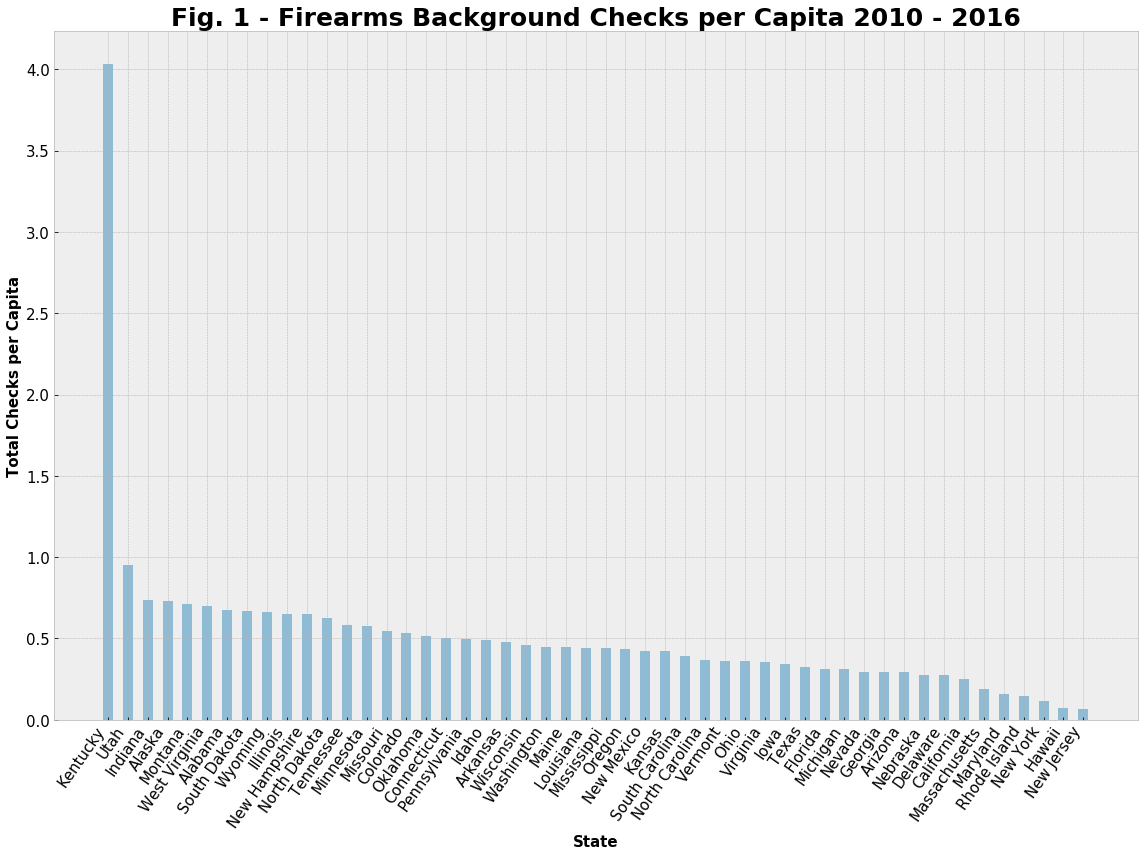

In [13]:
# Calculate checks per capita

checks_per_capita = ncis.groupby(['state']).sum()
checks_per_capita = checks_per_capita.join(pop_census, how='inner')
checks_per_capita = checks_per_capita.total / checks_per_capita.pop_est_16
checks_per_capita.sort_values(ascending=False, inplace=True)

# Set up bar-plot, sorted in descending order from left to right

plt.figure(figsize=(16, 12))
plt.title('Fig. 1 - Firearms Background Checks per Capita 2010 - 2016', size=25, weight='bold')
index = np.arange(len(checks_per_capita))
plt.bar(index, checks_per_capita, width=.5, alpha=.5, label=checks_per_capita.index)
plt.xlabel('State', size=15, weight='bold')
plt.ylabel('Total Checks per Capita', size=15, weight='bold')
plt.xticks(index, checks_per_capita.index, rotation=55, ha='right', size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.show()

More than 4 background checks per person over a 6 years period: There is definitly something weird going down in Kentucky.
<a id='quest1'></a>
### Research Question 1: Does turnover of firearms uniformly relate to gender, age, foreign-born, education or poverty demographics?

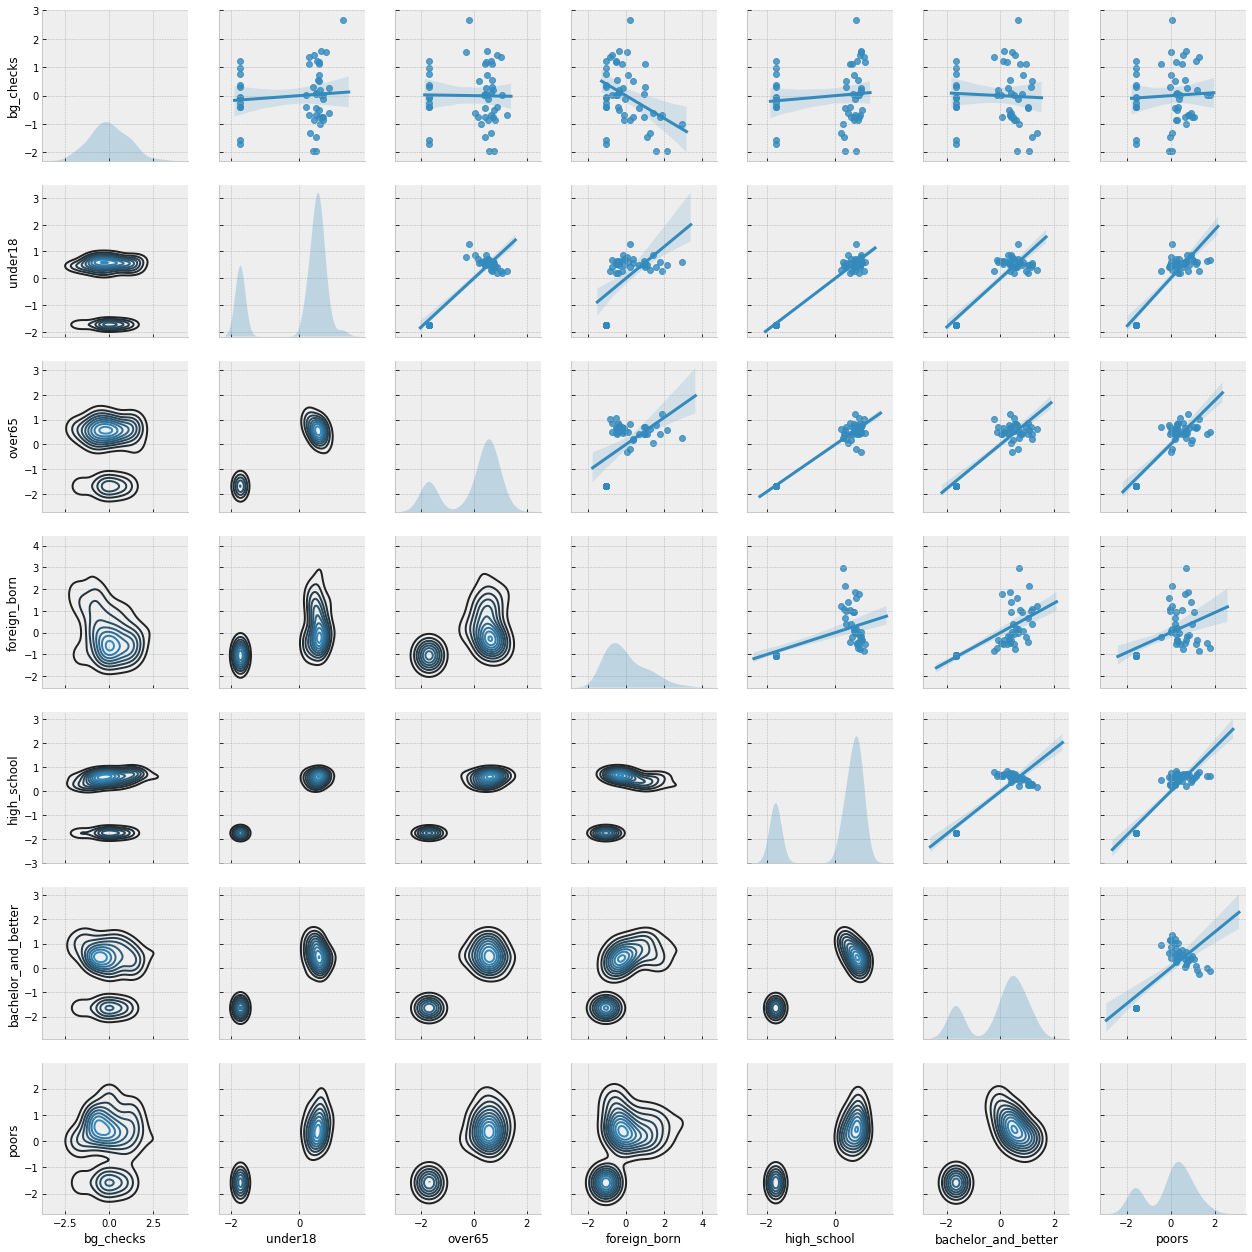

In [14]:
# Rearrange data set to isolate variables of interest

### Also, remove Kentucky, as it single-handedly blows all correlations ###

quest1 = checks_per_capita.to_frame(name='bg_checks').join(census)
quest1 = quest1.drop(['Kentucky'], axis=0).apply(z_transform, axis=0).reset_index()

# Plot variables pairwise against firearms turnover


g = sns.PairGrid(quest1, vars=['bg_checks',   'under18', 
                               'over65',      'foreign_born', 
                               'high_school', 'bachelor_and_better', 
                               'poors'])
g.map_upper(sns.regplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, shade=True, lw=0)
    
plt.tight_layout()
plt.show()

The primary axes of interest are the first row and the first column respectively. In the above example, Kentucky was excluded before calculating the z-score, as opposed to excluding it after the transformation but before plotting it. This way the picture is visually a bit less appealing, but it reveals an interesting observation: Including Kentucky in the transformation visibly increases the kurtosis. on as second glance, this makes sense as it is a tail observation and accordingly leads other observations to group stronger around the center of the distribution. Excluding Kentucky in the plot hides this fact, by making the distribution appear to have no skewness. Interesting side note: All other variables appear to follow a bi-modal distribution. But looking at the scatter plots, this tendency seems to be entirely driven by one more outlier. 

The strongest effect perceived may be a pleasently surprising one. There is a clear negative tendency between the number of performed background checks and the proportion of foreign-born populace in the state.
<a id='quest2'></a>
### Research Question 2: Does increasing gun-ownership correspond to a lower land-value?
We have two variables that serve as a proxy to land-value: i) The median value of owner-occupied housing units and ii) the median gross-rent as representation of the living standard and associated costs, or in the opposite case the difficulty of landlords to attract tenants. 

The rationale behind it is that land-value could be seen as an indicator for the attractiveness of a state to socially diverse communities or the ability of a place to retain a social and economical upper class. It aims to detect a possible link between popularity of firearms turnover and social precariousity.

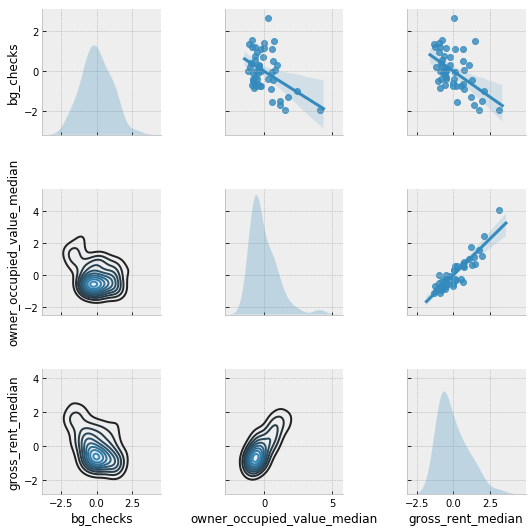

In [15]:
# Rearrange data set to isolate land value variables 

### Again, remove Kentucky ###

quest2 = checks_per_capita.to_frame(name='bg_checks').join(census)
quest2 = quest2.drop(['Kentucky'], axis=0).apply(z_transform, axis=0).reset_index()

# Plot variables pairwise against firearms turnover

g = sns.PairGrid(quest2, vars=['bg_checks',   'owner_occupied_value_median', 
                               'gross_rent_median'])
g.map_upper(sns.regplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, shade=True, lw=0)
    
plt.tight_layout()
plt.show()

How about that? The visuals indicate a strong negative relationship between land value and the number of gun checks performed in the state. Also, a the distributions of land value are all seemingly skewed to the right, indicating a number of states to really run up the score (e.g. Hawaii with $z = 4.07$ in housing-units value, i.e. more than 4 standard deviations above the mean).

In [16]:
# Z-scores for upper outlier in Owner-occupied houses value

quest2[quest2['owner_occupied_value_median'] == max(quest2['owner_occupied_value_median'])]

,state,bg_checks,foreign_born,owner_occupied_value_median,gross_rent_median,bachelor_and_better,poors,high_school,over65,under18
47,Hawaii,-1.930771,1.567127,4.068041,3.100222,0.630286,-0.094831,0.608407,0.771702,0.411925


<a id='quest3'></a>
### Research Question 3:  What was the overall trend across all states? How did the states diverge compared to each other?

With this one, let us try to find a comprehensive way to portrait the national trend, without loosing the information content of the individual observations to aggregation. We can plot the development of the NCIS' data distribution on a time axis, increasing the dimension by 1, yielding us two options to slice the set for further analysis: Longitudinal, i.e. along the time axis, and cross-sectional, i.e. through all states at each point in time.

Figure 4 represents the prior.

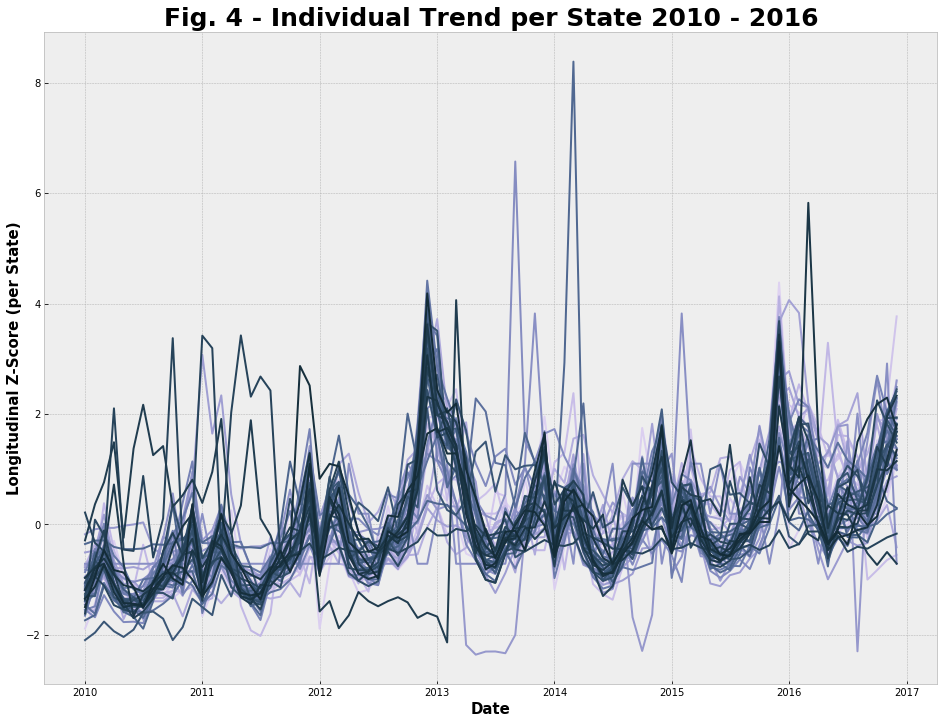

In [17]:
# Time trend for each individual state

quest3 = ncis.reset_index()

# To make individual states' trends comparable to one-another, we express
# each state's momentary number of background checks as the divergence
# from the long-term mean

quest3['trend_absolute'] = quest3.groupby(['state'])['total'].apply(z_transform)

# Now we can detect visible patterns

plt.figure(figsize=(16, 12))
plt.title('Fig. 4 - Individual Trend per State 2010 - 2016', size=25, weight='bold')
sns.lineplot(x='month', y='trend_absolute', hue='state',data=quest3, palette='ch:2.5,.25', legend=False)
plt.xlabel('Date', size=15, weight='bold')
plt.ylabel('Longitudinal Z-Score (per State)', size=15, weight='bold')
plt.show()

Fig. 4 exhibits a tiny upwards trend, consistent with the expectation of a growing economy, with a visible seasonal component. While most states appear to follow closely the overall trends, even with the dispersion among individual states generally decreasing after 2012, there are single notable exceptions. There are several modes crossing the $2\sigma$ threshold below their average distribution, even without detrending: A one year trend in 2012 reaching its minimum in early 2013, an even deeper drop in another state in spring 2013, and two short spikes in the summers of 2014 and 2016. 
The graphic suggests on the other side a heavy right-sided tail, with more upwards outliers between 2010 and 2012 than on the down-side, a nationwide surge in the end of 2013 and three maxima in Q3 2013, Q1 2014 and in Q1 2016. 
The seasonal component seems to peak usually in the late year.

Next, we have a closer look, on how the trends go into different directions between the different states. By normalizing the data along the time axis, we the individual states become comparable, regardless of e.g. differences in population or the absolut number of checks performed. From there, it is possible to slice out a single month and put every state's momentary number of background checks in relationship to what would the expected value for that respective month be, as suggested by Figure 4. 

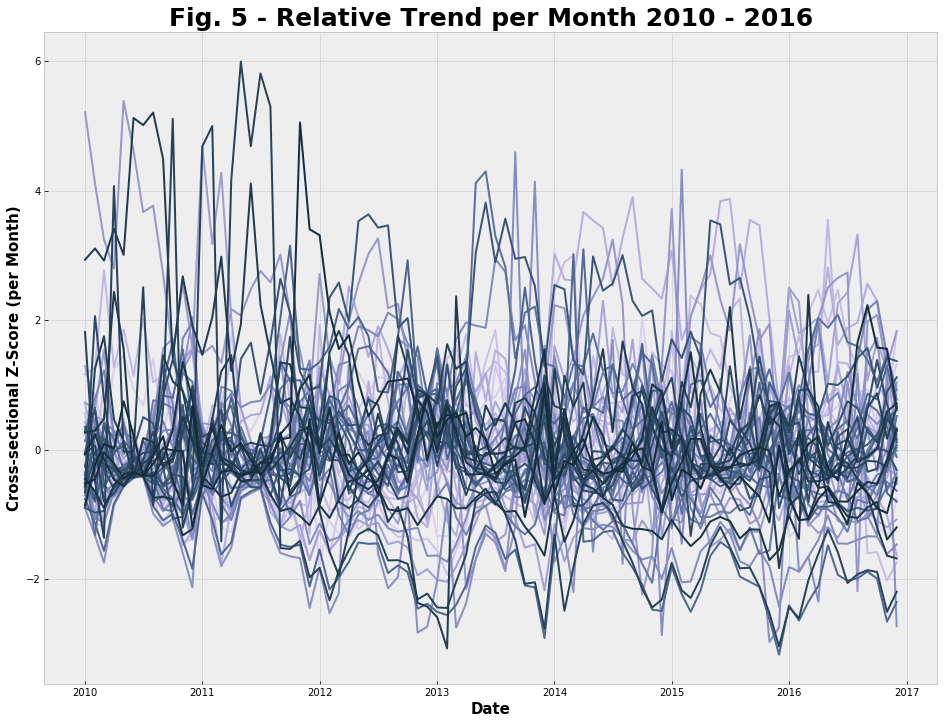

In [18]:
# Same approach, different anlge: This time we look at how relatively to each other
# the individual state's numbers diverge from the momentary national average

quest3['trend_relative'] = quest3.groupby(['state'])['total'].apply(normalize)
quest3['trend_relative'] = quest3.groupby(['month'])['trend_relative'].apply(z_transform)

# Seems a bit more erratic, but we can still identify patterns

plt.figure(figsize=(16, 12))
plt.title('Fig. 5 - Relative Trend per Month 2010 - 2016', size=25, weight='bold')
sns.lineplot(x='month', y='trend_relative', hue='state',data=quest3, palette='ch:2.5,.25', legend=False)
plt.xlabel('Date', size=15, weight='bold')
plt.ylabel('Cross-sectional Z-Score (per Month)', size=15, weight='bold')
plt.show()

Figure 5 looks more erratic than the prior one, but for a good reason: We would expect to find only white noise if all states were subject to identical dynamics. On first sight, the general relative trend seems to be normally distributed, until we observe the tail to skew twice as strong to the right than two the left, specifically between 20120 and 2012. Looking closer other patters shine through: E.g. suprisingly, the seasonal amplitudes do not completely vanish, suggesting that in some states it is more pronounced than in others, and there is a steep drop in dispersion around Q4 2012 and Q1 2013, exactly where we see the almost uniform spike in Figure 4. Moving along the time axis, the skewness seems to slowly reduce - possibly even to Null in 2016, suggesting that the overall randomness increases, meaning that state-dependent patterns would be statistically indistinguishable.

If plotted along the cumulative density of the distribution, it can be shown more clearly, what is happing on a national level. Figure 6 and 7 deliver a coherent spatial view over the persistence of patterns.

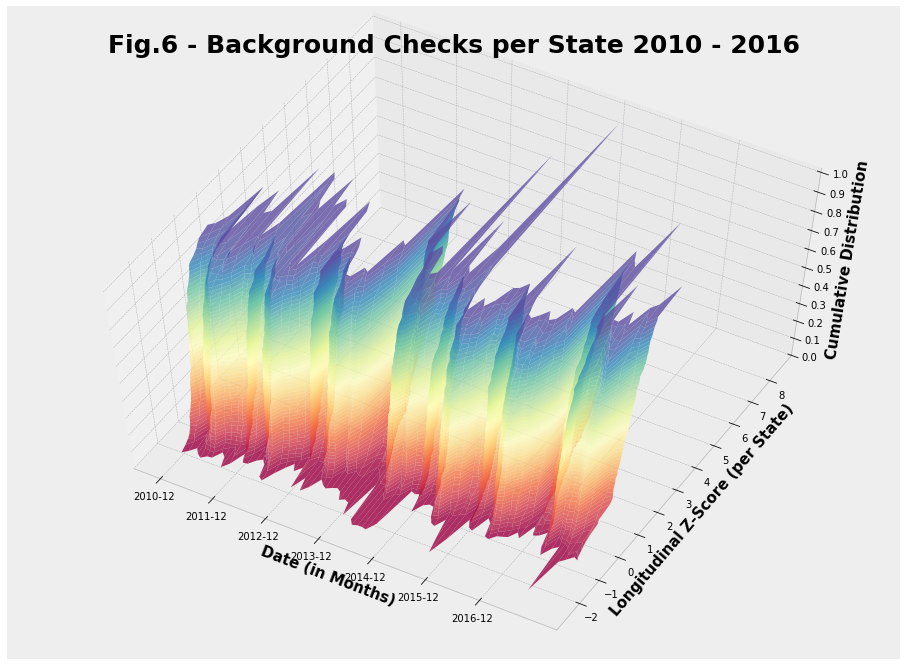

In [19]:
from dateutil import relativedelta

# Retrieving a numerical time axis in terms of delta t for later plotting,
# keeping the formatted dates for later

minimum = min(quest3['month'])
quest3['delta_t'] = [delta.years * 12 + delta.months for delta in [relativedelta.relativedelta(delta, minimum) for delta in quest3['month']]]
dates = list(pd.unique(quest3['month'].dt.to_period('M')))
X = quest3.pivot(index='month', columns='state', values='delta_t')

# Next, we calculate the cross-sectional ecdf for each point in time

Y, Z = zip(*list(quest3.groupby(['month'])['trend_absolute'].apply(ecdf)))
Y = np.vstack(Y)
Z = np.vstack(Z)

# Create 3D surface plot with z = quantile of state within cross-section

fig = plt.figure(figsize=(16, 12))
ax = fig.gca(projection='3d')
plt.title('Fig.6 - Background Checks per State 2010 - 2016', size=25, weight='bold')

# Plot the surface

surf = ax.plot_surface(X, Y, Z, cmap='Spectral', cstride=1, rstride=1, alpha=.8, antialiased=True, shade=False)

# Beautify

ax.set_xticks(np.arange(0, 84, 12))
ax.set_yticks(np.arange(-2, 9, 1))
ax.set_zticks(np.arange(0, 1.1, .1))
ax.xaxis.set_ticklabels(sorted(dates[0:73:12]))
ax.set_xlabel('Date (in Months)', size=15, weight='bold')
ax.set_ylabel('Longitudinal Z-Score (per State)', size=15, weight='bold')
ax.set_zlabel('Cumulative Distribution', size=15, weight='bold')
ax.view_init(60, -60)
plt.show()

Figure 4 showed the plan view perspective of this Figure. The slope indicates the concentration of observations around a point on the surface with the thinness of the tails showing the prevelance of outliers. The bright yellow horizontal indicates the median for each month. 

In [ ]:
# Retrieving a numerical time axis in terms of delta t for later plotting,
# keeping the formatted dates for later

minimum = min(quest3['month'])
quest3['delta_t'] = [delta.years * 12 + delta.months for delta in [relativedelta.relativedelta(delta, minimum) for delta in quest3['month']]]
dates = list(pd.unique(quest3['month'].dt.to_period('M')))
X = quest3.pivot(index='month', columns='state', values='delta_t')

# Next, we calculate the cross-sectional ecdf for each point in time

Y, Z = zip(*list(quest3.groupby(['month'])['trend_relative'].apply(ecdf)))
Y = np.vstack(Y)
Z = np.vstack(Z)

# Create 3D surface plot with z = quantile of state within cross-section

fig = plt.figure(figsize=(16, 12))
ax = fig.gca(projection='3d')
plt.title('Fig. 7 - Background Checks, relative Trend 2010 - 2016', size=25, weight='bold')

# Plot the surface

surf = ax.plot_surface(X, Y, Z, cmap='Spectral', cstride=1, rstride=1, alpha=.8, antialiased=True, shade=False)

# Beautify

ax.set_xticks(np.arange(0, 84, 12))
ax.set_yticks(np.arange(-2, 7, 1))
ax.set_zticks(np.arange(0, 1.1, .1))
ax.xaxis.set_ticklabels(sorted(dates[0:73:12]))
ax.set_xlabel('Date (in Months)', size=15, weight='bold')
ax.set_ylabel('Cross-sectional Z-Score (per Month)', size=15, weight='bold')
ax.set_zlabel('Cumulative Distribution', size=15, weight='bold')
ax.view_init(60, -60)
plt.show()

Similarly, Figure 7 is equivalent to Figure 5. We see the slope decreasing over time, supporting our observation from before that the individual trends appear to slowly converge to normal distribution. Also, moving along the median line again, we find less convolution on the surface area, which stands seemingly in contrast to our observation, that seasonal patterns persist relatively between states, but it does not invalidate it, as it is still visible in the tails of the distribution.

<a id='conclusions'></a>
## Conclusions

Our investigation has made a number of patterns visible and questioned some intuition about demographic relationships with the number of background checks conducted. While most of the demographics do not appear to have a strong correlation with background checks, the overall wealth of a state and possibly the social dispersion within the states does. Compared to each other, the states are increasingly normally distributed moving along the time axis. While there are outliers persistently skewed to the right side of the distribution until mid 2012, those amplitudes stand singular in the more recent years, well-defined in durance, but with astonishing magnitude hitting up to $8\sigma$ in late 2014. We do seem to have a general partisan trend in both tails of the distribution among states, but generally speaking there is no indication to assume a change in the trend of background checks and guns equivalently becoming more and more established in the society nationwide.

As mentioned in the introduction, the goal for gun violence research would be to draw any definitive line between private gun ownership and the prevalence of violent incidents, to either reject or approve of the hypothesis that the availability of firearms in the private states directly links to their abuse. Unfortunately, one has to be very careful in the analysis to make any conclusions related to this issue, as mentioned before, because the actual number of private guns can only be estimated and the quality of data varies widely from state to state, depending on how the indivdiual states participate in the NCI System. Also, at the cut off points of our research interval, we may easliy find perturbations in the preciseness of the definition of our variables, as we are trying to combine two wildly different types of data set, with cross-sectional data on the one hand and time-series data on the other. Some of the relationships were entirely hijacked by outliers, even after handling other even stronger outliers before. It proves, that comparing states in this manner has to be taken with a pinch of salt as most of the observations made here are likely symptoms of deeper unobserved structural variables, that reach from public consensus, social culture and political environment. Any other observations should only be seen as indicative and definitive conclusions are subject to further research.

## *Submitting your Project*

> *Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).*

> *Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.*

> *Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!*

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])